Import Libraries and Dataset




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print(" All libraries imported successfully!")

"""## 1. Data Loading and Exploration"""

from google.colab import files
import io

# Upload your dataset
uploaded = files.upload()

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(" Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

 All libraries imported successfully!


Saving rwandan_household_energy.csv to rwandan_household_energy (1).csv
 Dataset loaded successfully!
Dataset shape: (11000, 13)


Exploratory Data Analysis and Preprocessing


In [2]:
# Display basic information
print("\n Dataset Overview:")
print(df.head())

print("\n Dataset Info:")
print(df.info())

print("\n Statistical Summary:")
print(df.describe())

print("\n Missing Values:")
print(df.isnull().sum())

# Create a copy of the original data
df_processed = df.copy()

# Display unique values for categorical columns
print(" Categorical Variables Analysis:")
categorical_cols = ['Appliance', 'Region', 'Income_Level', 'Tariff_Bracket', 'Month']
for col in categorical_cols:
    print(f"\n{col}: {df_processed[col].unique()}")


 Dataset Overview:
  Household_ID        Appliance  Power_Watts  Usage_Hours_Daily  Quantity  \
0      HH00001           Laptop           57                7.1         2   
1      HH00002             Iron         1041                4.4         3   
2      HH00003  Washing Machine          562                5.3         1   
3      HH00004     Water Heater         1804                3.5         1   
4      HH00005            Radio           44                6.7         1   

   Usage_Days_Monthly    Region Income_Level  Household_Size  \
0                  27   Eastern         High               1   
1                  23   Eastern         High               6   
2                  28   Eastern          Low               6   
3                  30  Southern         High               7   
4                  25    Kigali         High               5   

   Total_kWh_Monthly Tariff_Bracket  Estimated_Bill_RWF    Month  
0              21.85      21-50 kWh             6773.50    March 

Data Visualization

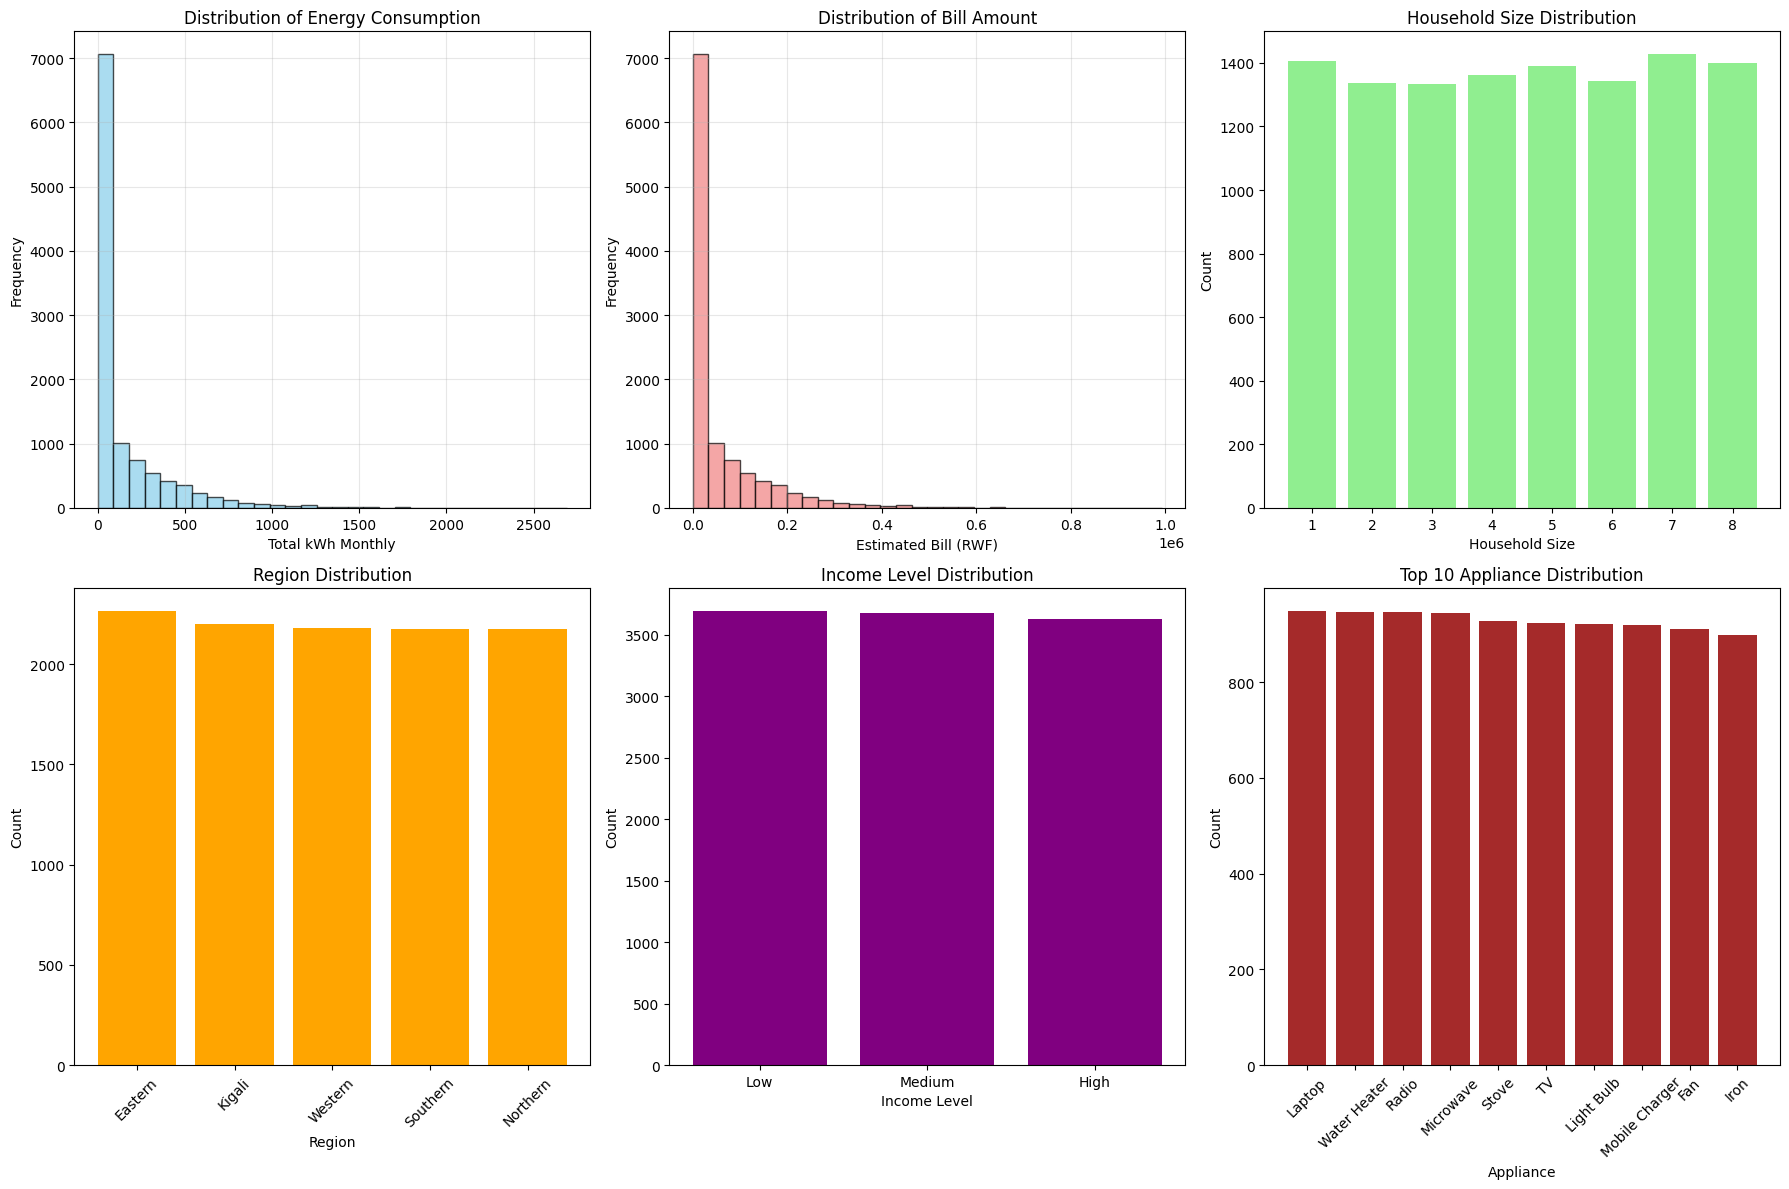

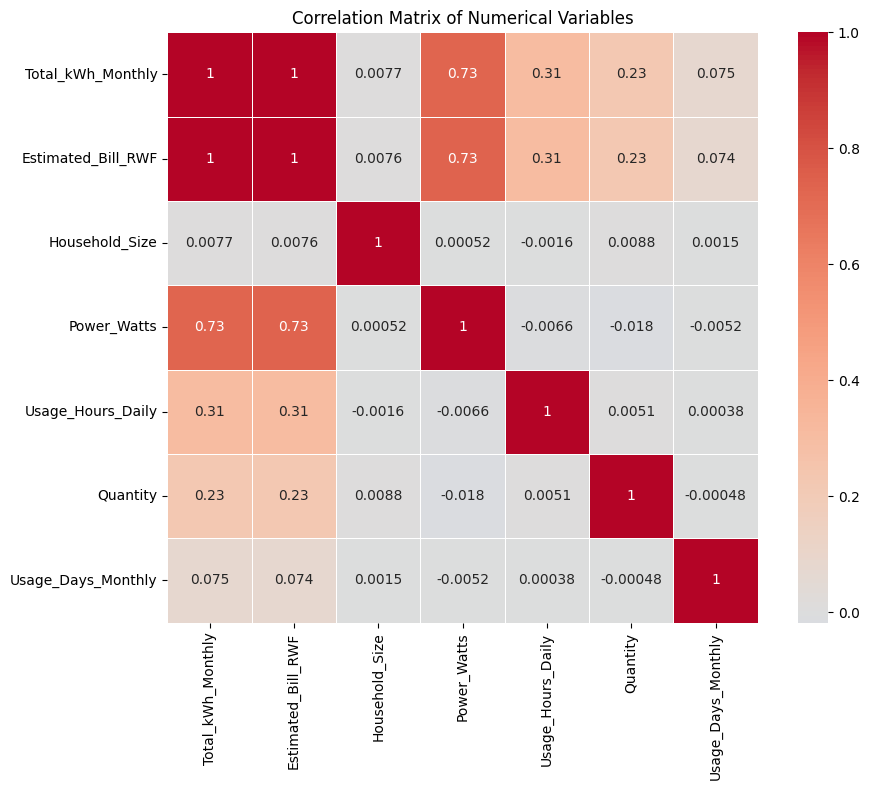

In [3]:
# Create initial visualizations for data understanding
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of Energy Consumption
axes[0,0].hist(df_processed['Total_kWh_Monthly'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Total kWh Monthly')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Energy Consumption')
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution of Bill Amount
axes[0,1].hist(df_processed['Estimated_Bill_RWF'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_xlabel('Estimated Bill (RWF)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Bill Amount')
axes[0,1].grid(True, alpha=0.3)

# 3. Household Size Distribution
household_counts = df_processed['Household_Size'].value_counts().sort_index()
axes[0,2].bar(household_counts.index, household_counts.values, color='lightgreen')
axes[0,2].set_xlabel('Household Size')
axes[0,2].set_ylabel('Count')
axes[0,2].set_title('Household Size Distribution')

# 4. Region Distribution
region_counts = df_processed['Region'].value_counts()
axes[1,0].bar(region_counts.index, region_counts.values, color='orange')
axes[1,0].set_xlabel('Region')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Region Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Income Level Distribution
income_counts = df_processed['Income_Level'].value_counts()
axes[1,1].bar(income_counts.index, income_counts.values, color='purple')
axes[1,1].set_xlabel('Income Level')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Income Level Distribution')

# 6. Appliance Distribution (Top 10)
appliance_counts = df_processed['Appliance'].value_counts().head(10)
axes[1,2].bar(appliance_counts.index, appliance_counts.values, color='brown')
axes[1,2].set_xlabel('Appliance')
axes[1,2].set_ylabel('Count')
axes[1,2].set_title('Top 10 Appliance Distribution')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical variables
numerical_cols = ['Total_kWh_Monthly', 'Estimated_Bill_RWF', 'Household_Size',
                  'Power_Watts', 'Usage_Hours_Daily', 'Quantity', 'Usage_Days_Monthly']

plt.figure(figsize=(10, 8))
correlation_matrix = df_processed[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

Data Preprocessing and Feature Engineering


In [4]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Region', 'Income_Level', 'Tariff_Bracket', 'Month', 'Appliance']

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f" Encoded {col}: {len(le.classes_)} categories")

# Create derived features for better clustering
df_processed['Daily_Energy_kWh'] = (df_processed['Power_Watts'] * df_processed['Usage_Hours_Daily'] * df_processed['Quantity']) / 1000
df_processed['Monthly_Energy_Estimate'] = df_processed['Daily_Energy_kWh'] * df_processed['Usage_Days_Monthly']
df_processed['Energy_Per_Capita'] = df_processed['Total_kWh_Monthly'] / df_processed['Household_Size']
df_processed['Bill_Per_Capita'] = df_processed['Estimated_Bill_RWF'] / df_processed['Household_Size']
df_processed['Cost_Per_kWh'] = df_processed['Estimated_Bill_RWF'] / df_processed['Total_kWh_Monthly']

print("\n Derived features created successfully!")
print(f"New dataset shape: {df_processed.shape}")

# Display new features
print("\n New Derived Features:")
print(df_processed[['Daily_Energy_kWh', 'Monthly_Energy_Estimate', 'Energy_Per_Capita',
                    'Bill_Per_Capita', 'Cost_Per_kWh']].describe())

# Features for Clustering (K-Means)
cluster_features = [
    'Total_kWh_Monthly',
    'Estimated_Bill_RWF',
    'Household_Size',
    'Income_Level_encoded',
    'Region_encoded',
    'Quantity',
    'Usage_Hours_Daily',
    'Energy_Per_Capita',
    'Bill_Per_Capita'
]

# Features for Anomaly Detection (Isolation Forest)
anomaly_features = [
    'Total_kWh_Monthly',
    'Estimated_Bill_RWF',
    'Usage_Hours_Daily',
    'Quantity',
    'Tariff_Bracket_encoded',
    'Region_encoded',
    'Month_encoded',
    'Daily_Energy_kWh',
    'Cost_Per_kWh'
]

print(" Selected Features for Clustering:")
print(cluster_features)

print("\n Selected Features for Anomaly Detection:")
print(anomaly_features)

# Prepare feature matrices
X_cluster = df_processed[cluster_features]
X_anomaly = df_processed[anomaly_features]

print(f"\n Clustering dataset shape: {X_cluster.shape}")
print(f" Anomaly detection dataset shape: {X_anomaly.shape}")

# Scale the features
scaler_cluster = StandardScaler()
scaler_anomaly = StandardScaler()

X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

print(" Features scaled successfully!")

 Encoded Region: 5 categories
 Encoded Income_Level: 3 categories
 Encoded Tariff_Bracket: 3 categories
 Encoded Month: 12 categories
 Encoded Appliance: 12 categories

 Derived features created successfully!
New dataset shape: (11000, 23)

 New Derived Features:
       Daily_Energy_kWh  Monthly_Energy_Estimate  Energy_Per_Capita  \
count      11000.000000             11000.000000       11000.000000   
mean           5.976652               152.120748          52.188994   
std            9.971540               256.482518         124.400968   
min            0.003500                 0.097200           0.015000   
25%            0.257600                 6.479150           1.580000   
50%            1.146150                28.582350           8.151250   
75%            7.782825               199.309200          49.549375   
max           89.640000              2689.200000        1940.290000   

       Bill_Per_Capita  Cost_Per_kWh  
count     11000.000000  11000.000000  
mean      18889.08

Build and Train the Neural Network Model


 Building Neural Network Models...
 Autoencoder model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,489 (25.35 KB)

 Trainable params: 6,489 (25.35 KB)

 Non-trainable params: 0 (0.00 B)

None
 Training Autoencoder...
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4864 - val_loss: 0.0097
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 8.7590e-04
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5561e-04 - val_loss: 8.2969e-04
Epoch 10/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3402e-04 - val_loss: 6.9882e-04
Epoch 11/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6900e-04 - val_loss: 6.897

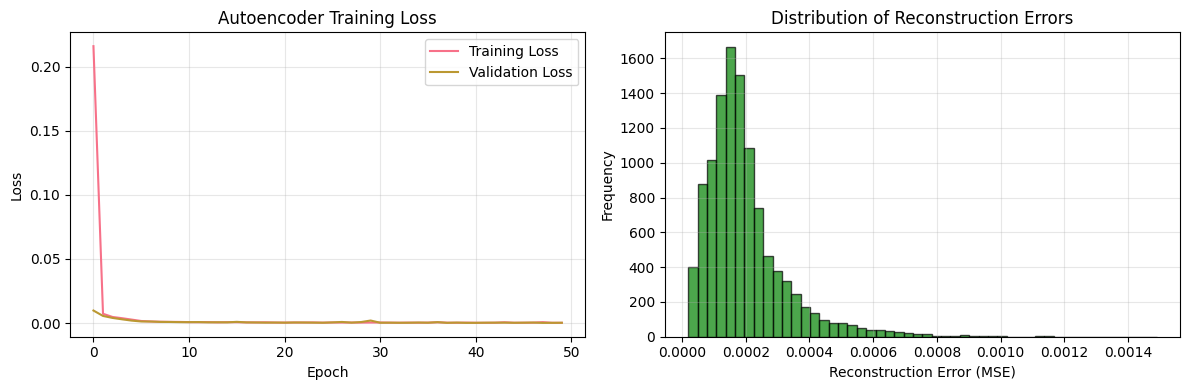

 Neural Network training completed!


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Since the main focus is clustering and anomaly detection, let's create an autoencoder for anomaly detection
print(" Building Neural Network Models...")

# Autoencoder for Anomaly Detection
def build_autoencoder(input_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)

    # Decoder
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return autoencoder

# Build and train autoencoder
autoencoder = build_autoencoder(X_anomaly_scaled.shape[1])
print(" Autoencoder model built successfully!")
print(autoencoder.summary())

# Train the autoencoder
print(" Training Autoencoder...")
history = autoencoder.fit(
    X_anomaly_scaled, X_anomaly_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate reconstruction error
reconstructions = autoencoder.predict(X_anomaly_scaled)
mse = np.mean(np.power(X_anomaly_scaled - reconstructions, 2), axis=1)
df_processed['Autoencoder_Reconstruction_Error'] = mse

plt.subplot(1, 2, 2)
plt.hist(mse, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Neural Network training completed!")

Model Evaluation


 Finding optimal number of clusters...
K=2: WCSS = 73364.84, Silhouette = 0.420
K=3: WCSS = 65826.21, Silhouette = 0.140
K=4: WCSS = 57682.42, Silhouette = 0.154
K=5: WCSS = 53072.13, Silhouette = 0.147
K=6: WCSS = 49943.29, Silhouette = 0.147
K=7: WCSS = 47059.74, Silhouette = 0.149
K=8: WCSS = 44310.63, Silhouette = 0.153
K=9: WCSS = 41813.30, Silhouette = 0.153
K=10: WCSS = 39561.81, Silhouette = 0.156


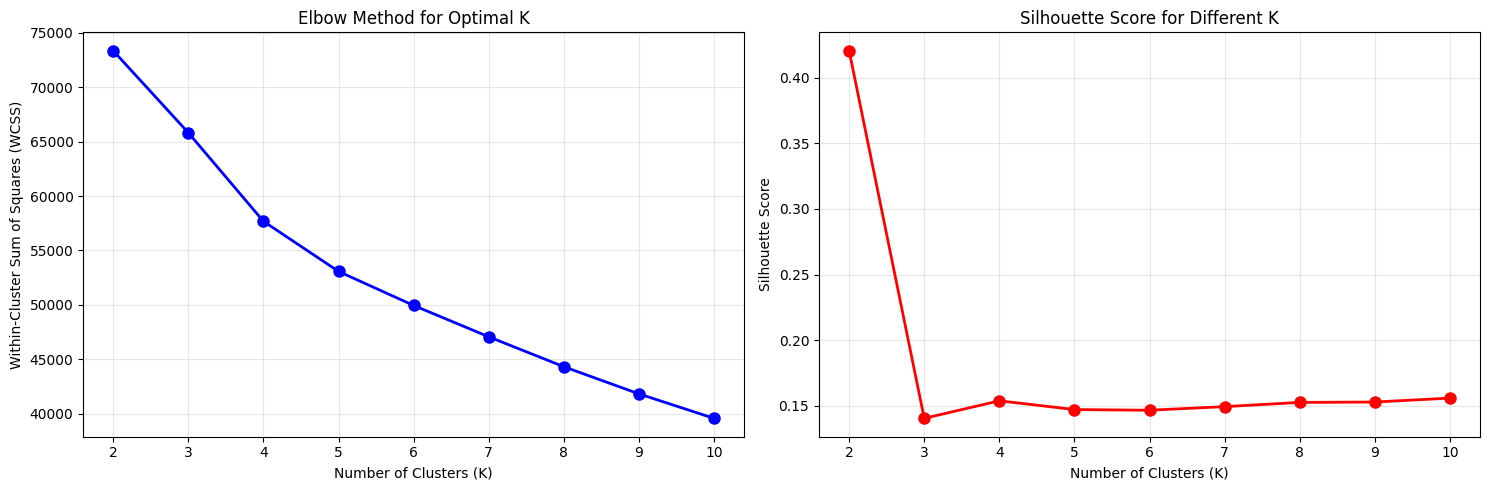

 K-Means clustering completed!
Cluster distribution:
Cluster
0    4884
1    4872
2    1244
Name: count, dtype: int64

 Clustering Metrics:
Silhouette Score: 0.140
Calinski-Harabasz Score: 2771.053
Davies-Bouldin Score: 1.997
 Anomaly detection completed!
Anomaly distribution:
Is_Anomaly
Normal     10450
Anomaly      550
Name: count, dtype: int64

 Autoencoder detected 550 anomalies
Isolation Forest detected 550 anomalies

 FINAL MODEL EVALUATION SUMMARY
Clustering Performance:
  - Optimal Clusters: 3
  - Silhouette Score: 0.140
  - Cluster Distribution: {0: np.int64(4884), 1: np.int64(4872), 2: np.int64(1244)}

Anomaly Detection Performance:
  - Isolation Forest Anomalies: 550
  - Autoencoder Anomalies: 550
  - Anomaly Rate: 5.0%

 Results saved to 'rwanda_energy_analysis_results.csv'


In [6]:
# Determine optimal number of clusters using Elbow Method and Silhouette Score
def find_optimal_clusters(X, max_k=10):
    wcss = []  # Within-Cluster Sum of Square
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

        # Silhouette Score
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        print(f"K={k}: WCSS = {kmeans.inertia_:.2f}, Silhouette = {silhouette_avg:.3f}")

    return k_range, wcss, silhouette_scores

print(" Finding optimal number of clusters...")
k_range, wcss, silhouette_scores = find_optimal_clusters(X_cluster_scaled)

# Plot Elbow Method and Silhouette Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)

# Silhouette Scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Apply K-Means with optimal K
optimal_k = 3  # Based on elbow and silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Add cluster labels to dataframe
df_processed['Cluster'] = cluster_labels

print(" K-Means clustering completed!")
print(f"Cluster distribution:\n{df_processed['Cluster'].value_counts().sort_index()}")

# Calculate clustering metrics
silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
calinski_score = calinski_harabasz_score(X_cluster_scaled, cluster_labels)
davies_score = davies_bouldin_score(X_cluster_scaled, cluster_labels)

print(f"\n Clustering Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Score: {calinski_score:.3f}")
print(f"Davies-Bouldin Score: {davies_score:.3f}")

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
anomaly_labels = iso_forest.fit_predict(X_anomaly_scaled)

# Convert labels: 1 = normal, -1 = anomaly
df_processed['Is_Anomaly'] = anomaly_labels
df_processed['Is_Anomaly'] = df_processed['Is_Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Calculate anomaly scores
anomaly_scores = iso_forest.decision_function(X_anomaly_scaled)
df_processed['Anomaly_Score'] = anomaly_scores

print(" Anomaly detection completed!")
print(f"Anomaly distribution:\n{df_processed['Is_Anomaly'].value_counts()}")

# Compare Autoencoder vs Isolation Forest anomalies
# Set threshold for autoencoder anomalies (top 5% reconstruction errors)
autoencoder_threshold = np.percentile(mse, 95)
df_processed['Autoencoder_Anomaly'] = mse > autoencoder_threshold

print(f"\n Autoencoder detected {df_processed['Autoencoder_Anomaly'].sum()} anomalies")
print(f"Isolation Forest detected {len(df_processed[df_processed['Is_Anomaly'] == 'Anomaly'])} anomalies")

# Final model comparison
print("\n" + "="*50)
print(" FINAL MODEL EVALUATION SUMMARY")
print("="*50)
print(f"Clustering Performance:")
print(f"  - Optimal Clusters: {optimal_k}")
print(f"  - Silhouette Score: {silhouette_avg:.3f}")
print(f"  - Cluster Distribution: {dict(df_processed['Cluster'].value_counts().sort_index())}")

print(f"\nAnomaly Detection Performance:")
print(f"  - Isolation Forest Anomalies: {len(df_processed[df_processed['Is_Anomaly'] == 'Anomaly'])}")
print(f"  - Autoencoder Anomalies: {df_processed['Autoencoder_Anomaly'].sum()}")
print(f"  - Anomaly Rate: {len(df_processed[df_processed['Is_Anomaly'] == 'Anomaly'])/len(df_processed)*100:.1f}%")

# Save the processed data with clusters and anomalies
df_processed.to_csv('rwanda_energy_analysis_results.csv', index=False)
print(f"\n Results saved to 'rwanda_energy_analysis_results.csv'")

anomaly detection graph metrics

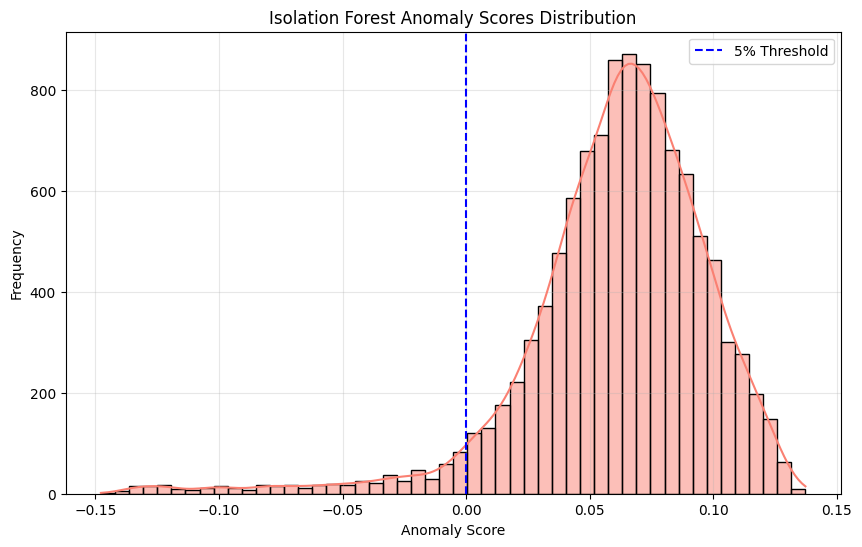

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['Anomaly_Score'], bins=50, kde=True, color='salmon')
plt.axvline(x=np.percentile(df_processed['Anomaly_Score'], 5), color='blue', linestyle='--', label='5% Threshold')
plt.title("Isolation Forest Anomaly Scores Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


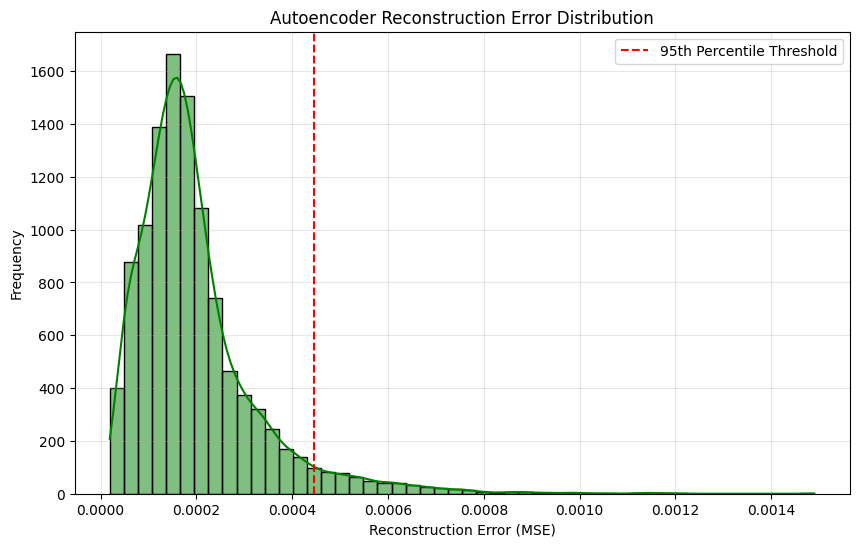

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['Autoencoder_Reconstruction_Error'], bins=50, kde=True, color='green')
plt.axvline(x=autoencoder_threshold, color='red', linestyle='--', label='95th Percentile Threshold')
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
